In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.dates as mdates  # Importing module for date formatting
import matplotlib.ticker as ticker  # Importing ticker for customizing colorbar ticks
from scipy.ndimage import gaussian_filter
import glob
from datetime import datetime

# all open cellular cells identified in KAZR

In [5]:
def time_height_transect(start_time, end_time):
    # Data path
    path = "/glade/work/noteng/otengn1/240475/"
    data = "KAZR/anxarsclkazr1kolliasM1/"
     # retrieving temperature
    data2 = "interpsonde/"
    
    # combine dataset
    data = glob.glob(f"{path}{data}*.nc")
    data_sonde = glob.glob(f"{path}{data2}*.nc")
   
    # ds = xr.open_mfdataset(data, combine='time')
    ds = xr.open_mfdataset(data)
    ds1 = xr.open_mfdataset(data_sonde)

    
    # selected time
    ds = ds.sel(time=slice(start_time, end_time))   
    ds1 = ds1.sel(time=slice(start_time , end_time))
    
    
    # data variables
    reflectivity = ds['reflectivity_best_estimate']
    doppler_velocity = ds['mean_doppler_velocity']
    spectral_width = ds['spectral_width']
    lwp = ds['mwr_lwp']
    precip = ds['precip_mean']
    temp = ds1['temp']
    
    # Apply Gaussian smoothing
    smoothed_reflectivity = gaussian_filter(reflectivity, sigma=0)  # Adjust sigma for desired smoothing level
    smoothed_doppler_velocity = gaussian_filter(doppler_velocity, sigma=0)  # Adjust sigma for desired smoothing level
    smoothed_spectral_width = gaussian_filter(spectral_width, sigma=0)  # Adjust sigma for desired smoothing level

    fig, ax = plt.subplots(figsize=(27, 15), nrows=4, ncols=1, sharex=True)
    ax = ax.flatten()
    
    #  # Add text outside the box of the first figure
    # text = "Example Text"
    # fig.text(0.5, 1.05, text, fontsize=18, ha='left')

    
    # print(len(ax)-1) # last axis
    for i, v in enumerate(ax):
        labels = ["(a)", "(b)", "(c)", "(d)"]
    
   
        # Add text to the subplots
        ax[i].text(0.004, 0.97, labels[i], transform=ax[i].transAxes,
                   fontsize=18, va='top', ha='left')
        if i == 0:
            pcm = ax[i].pcolormesh(ds['time'], reflectivity['height'] / 1000.0, smoothed_reflectivity.T, 
                                   cmap='nipy_spectral', vmin=-30, vmax=25, zorder=5)
            # temperature
            cntr = ax[i].contour(temp['time'][::2], temp['height'][::2], np.transpose(temp.values)[::2, ::2], 
                          np.round(np.arange(-100,320, 10)), colors='k', linewidths=0.8, linestyles ="dashed", zorder=6)
            plt.clabel(cntr,inline=1, inline_spacing=8, fontsize=20, fmt='%i',manual=False)
            ax[i].set_ylim(0, 7)
            # Set y-axis ticks
            ax[i].set_yticks(np.arange(1, 8))
            ax[i].tick_params(axis='y', labelsize=15)
            ax[i].set_ylabel('Height [km]', color='black', fontsize=15)  # Label for the twin y-axis
            cbar = fig.colorbar(pcm, ax=ax[i])
            cbar.set_label('Reflectivity [dBZ]', fontsize=15)
             # Set colorbar ticks at an interval of 10 (adjust as needed)
            tick_locator = ticker.MultipleLocator(base=10)
            cbar.locator = tick_locator
            cbar.update_ticks()

        if i == 1:
            pcm = ax[i].pcolormesh(ds['time'], reflectivity['height']/1000.0, smoothed_doppler_velocity.T,
                                   cmap='bwr', vmin=-3, vmax=1, zorder=5)
            ax[i].set_ylim(0, 7)
            # Set y-axis ticks
            ax[i].set_yticks(np.arange(1, 8))
            ax[i].tick_params(axis='y', labelsize=15)
            ax[i].set_ylabel('Height [km]', color='black', fontsize=15)  # Label for the twin y-axis
            cbar = fig.colorbar(pcm, ax=ax[i], extend='both')
            cbar.set_label("Doppler\nVelocity [m s$^{-1}$]", fontsize=15)


        if i == 2:
            pcm = ax[i].pcolormesh(ds['time'], reflectivity['height']/1000.0, smoothed_spectral_width.T,
                                   cmap='Blues', vmin=0, vmax=1, zorder=5)
            ax[i].set_ylim(0, 7)
            # Set y-axis ticks
            ax[i].set_yticks(np.arange(1, 8))
            ax[i].tick_params(axis='y', labelsize=15)
            ax[i].set_ylabel('Height [km]', color='black', fontsize=15)  # Label for the twin y-axis
            cbar = fig.colorbar(pcm, ax=ax[i], extend='max')
            cbar.set_label("Spectral\nWidth [m s$^{-1}$]", fontsize=15)

        if i == 3:
            pcm = ax[i].scatter(lwp['time'], np.divide(lwp.values, 1000), color='blue', zorder=3, s=1)
            ax[i].set_yticks(np.arange(0, round(np.nanmax(np.divide(lwp.values, 1000)))+0.1, 0.5))
            ax[i].spines['left'].set_color('blue')
            ax[i].tick_params(axis='y', colors='blue', labelsize=15)
            ax[i].set_ylabel("LWP [kg m$^{-2}$]", c = "blue", fontsize=15)
            cbar = fig.colorbar(pcm, ax=ax[i], extend='neither')
            # set colorbar to invisible
            cbar.ax.set_visible(False)
            ax[3].grid(axis="y", ls = '--', c = "blue",alpha = 0.5)

            # Create a twin y-axis for ax[2]
            ax31 = ax[i].twinx()
            ax31.scatter(lwp['time'], precip, color='black', s=1)
            ax31.spines['right'].set_color('black')
            ax31.tick_params(axis='y', colors='black', labelsize=15)
            ax31.set_ylabel('Precip Rate [mm/hr]', color='black', fontsize=15)  # Label for the twin y-axis
            ax31.set_yticks(np.arange(0, round(np.max(precip.values))+0.1 ))
            ax31.grid(axis="y", ls = '--', c = "black",alpha = 0.5)


        # Custom datetime format
        custom_date_format = "%H:%M UTC\n%d %B %Y"  # Format: 04:00 UTC\n13 March 2020
        # Formatting the time labels
        ax[len(ax)-1].xaxis.set_major_formatter(mdates.DateFormatter(custom_date_format))
        # Including the first-date and last-date on the plot
        ax[len(ax)-1].set_xlim([ds['time'].min(), ds['time'].max()])
        # Set custom tick positions for the x-axis
        num_ticks = 11  # Number of tick labels
        tick_positions = np.linspace(0, len(ds['time']) - 1, num_ticks, dtype=int)
        ax[len(ax)-1].set_xticks(ds['time'][tick_positions])

        # Generate custom tick labels including the first and last dates
        tick_labels = [ds['time'][pos].dt.strftime(custom_date_format).values for pos in tick_positions]
        tick_labels[0] = ds['time'].min().dt.strftime(custom_date_format).values  # First date
        tick_labels[-1] = ds['time'].max().dt.strftime(custom_date_format).values  # Last date
        ax[len(ax)-1].set_xticklabels(tick_labels, fontsize=13.5, rotation=0);  # You can adjust fontsize and rotation

        # fig.savefig("open-cells-time-height-transect-all-cells.png", dpi=500, bbox_inches='tight')

CPU times: user 4.93 s, sys: 1.06 s, total: 5.99 s
Wall time: 6.15 s


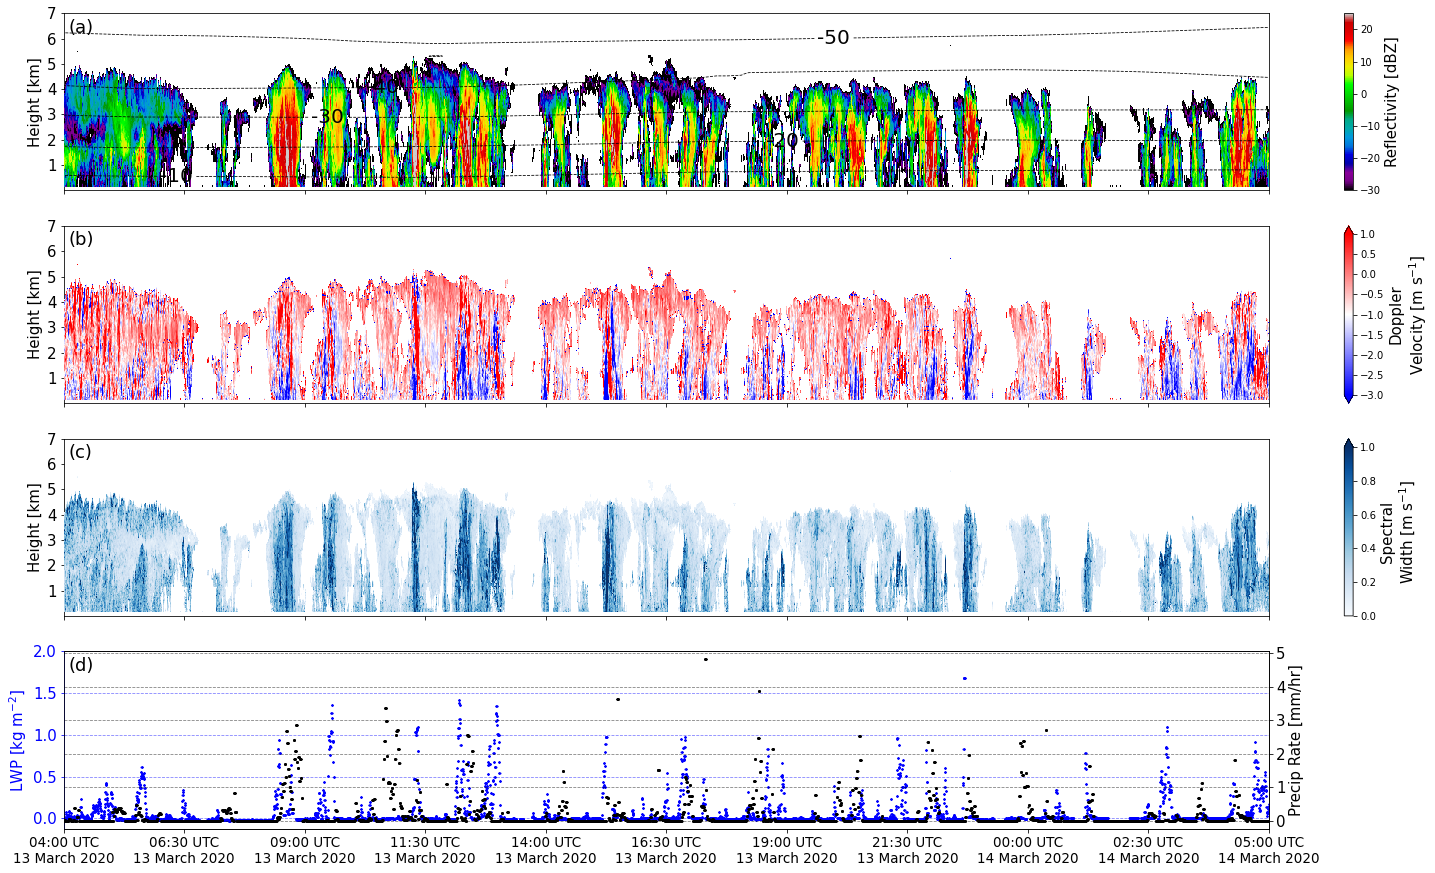

In [6]:
%%time
time_height_transect('2020-03-13T04:00:00.000000000', '2020-03-14T05:00:00.000000000')